# Potato Chips Sales Analysis 2


You are part of Quantium’s retail analytics team and have been approached by your client. The Category Manager for Chips has asked us to test the impact of the new trial layouts with a data driven recommendation to whether or not the trial layout should be rolled out to all their stores. For this part of the project we will be examining the performance in trial vs control stores to provide a recommendation for each location based on our insight. It involves selecting Control Stores and Assessment of the trial – this one should give you some interesting insights into each of the stores, check each trial store individually in comparison with the control store to get a clear view of its overall performance. We want to know if the trial stores were successful or not.

You have been asked to evaluate the performance of a store trial which was performed in stores 77, 86 and 88.

Create a measure to compare different control stores to each of the trial stores to do this write a function to reduce having to re-do the analysis for each trial store. Consider using Pearson correlations or a metric such as a magnitude distance e.g. 1- (Observed distance – minimum distance)/(Maximum distance – minimum distance) as a measure.

Once you have selected your control stores, compare each trial and control pair during the trial period. You want to test if total sales are significantly different in the trial period and if so, check if the driver of change is more purchasing customers or more purchases per customers etc.

The above are the instructions given to us by the Manager. In summary, the company ran an experiment on some stores(77,86,88) and wants us to evaluate if the experiment was a success. To track how it performs, they need a control store to compare it with. By control store i mean a store that is very similar in every way to the trial store prior to the experiment. Reason  being that when the trial store is being observed during the trial phase, it can be compared to the progress of the control store(which would have been the same progress of the trial store, if the experiment was not done on the trial store).



In [1]:
#Starting by importing the necessary libraries and provided data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('QVI_data.csv')

In [3]:
#The data is the same as the one used in the first part
df 


,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream
...,...,...,...,...,...,...,...,...,...,...,...,...
264829,2370701,2018-12-08,88,240378,24,Grain Waves Sweet Chilli 210g,2,7.2,210,GRNWVES,YOUNG FAMILIES,Mainstream
264830,2370751,2018-10-01,88,240394,60,Kettle Tortilla ChpsFeta&Garlic 150g,2,9.2,150,KETTLE,YOUNG FAMILIES,Premium
264831,2370961,2018-10-24,88,240480,70,Tyrrells Crisps Lightly Salted 165g,2,8.4,165,TYRRELLS,OLDER FAMILIES,Budget
264832,2370961,2018-10-27,88,240481,65,Old El Paso Salsa Dip Chnky Tom Ht300g,2,10.2,300,OLD,OLDER FAMILIES,Budget


In [4]:
#Lets turn the date to datetime,because it plays a big role in this project
from datetime import datetime

In [5]:
df['DATE'] = pd.to_datetime(df['DATE']) 

In [6]:
df['DATE'] = df['DATE'].apply(lambda x : x.strftime('%Y-%m')) #we need only the year and month

In [7]:
df['DATE'].unique()

array(['2018-10', '2018-09', '2019-03', '2018-11', '2018-12', '2018-07',
       '2019-06', '2019-04', '2019-01', '2018-08', '2019-05', '2019-02'],
      dtype=object)

# Finding Control Stores

We have data from july 2018 to june 2019. The trial and observation period is from February 2019 to April 2019. In order to find our control stores, we would need to seperate the data to pre trial period(July 2018 - January 2019) and trial period.

In [8]:
pretrial = df[(df['DATE'] >= '2018-07') & (df['DATE']<='2019-01')]

As we did in the first analysis, i would be creating a table that summarises the data to show the transaction history of each store by month

In [9]:
monthly_totsales = pretrial.pivot_table(index=['STORE_NBR','DATE'], values = ['TOT_SALES','PROD_QTY'], 
                                        aggfunc = np.sum).reset_index()
monthly_totsales

,STORE_NBR,DATE,PROD_QTY,TOT_SALES
0,1,2018-07,62,206.9
1,1,2018-08,54,176.1
2,1,2018-09,75,278.8
3,1,2018-10,58,188.1
4,1,2018-11,57,192.6
...,...,...,...,...
1843,272,2018-09,71,304.7
1844,272,2018-10,99,430.6
1845,272,2018-11,87,376.2
1846,272,2018-12,89,403.9


In [10]:
#To know the number of customers that bought chips in each store for every month
monthly_customers = pretrial.groupby(['STORE_NBR','DATE'])['LYLTY_CARD_NBR'].nunique().reset_index()

In [11]:
#To know the number of transactions carried out in each store for every month
monthly_transactions = pretrial.groupby(['STORE_NBR','DATE'])['TXN_ID'].nunique().reset_index()

In [12]:
monthly_pretrial1 = pd.merge(monthly_totsales,monthly_customers, on = ['STORE_NBR','DATE'], how = 'outer')

In [13]:
monthly_pretrial = pd.merge(monthly_pretrial1, monthly_transactions, on= ['STORE_NBR','DATE'], how = 'outer')

In [14]:
monthly_pretrial['TXN/CUSTOMER'] = monthly_pretrial['TXN_ID']/monthly_pretrial['LYLTY_CARD_NBR']

In [15]:
monthly_pretrial['CHIPS/CUSTOMER'] = monthly_pretrial['PROD_QTY']/monthly_pretrial['LYLTY_CARD_NBR']

In [16]:
monthly_pretrial['AVG_PRICE/CHIP'] = monthly_pretrial['TOT_SALES']/monthly_pretrial['PROD_QTY']

In [17]:
monthly_pretrial

,STORE_NBR,DATE,PROD_QTY,TOT_SALES,LYLTY_CARD_NBR,TXN_ID,TXN/CUSTOMER,CHIPS/CUSTOMER,AVG_PRICE/CHIP
0,1,2018-07,62,206.9,49,52,1.061224,1.265306,3.337097
1,1,2018-08,54,176.1,42,43,1.023810,1.285714,3.261111
2,1,2018-09,75,278.8,59,62,1.050847,1.271186,3.717333
3,1,2018-10,58,188.1,44,45,1.022727,1.318182,3.243103
4,1,2018-11,57,192.6,46,47,1.021739,1.239130,3.378947
...,...,...,...,...,...,...,...,...,...
1843,272,2018-09,71,304.7,32,36,1.125000,2.218750,4.291549
1844,272,2018-10,99,430.6,44,50,1.136364,2.250000,4.349495
1845,272,2018-11,87,376.2,41,45,1.097561,2.121951,4.324138
1846,272,2018-12,89,403.9,47,47,1.000000,1.893617,4.538202


At this point PROD_QTY represents the total number of chips bought in that store for that month

TOT_SALES represents the total sales made in that store for that month.

LYLTY_CARD_NBR represents the number of customers that bouught chips in that store for that month.

TXN_ID represents the number of transactions made in that store for that month.

TXN/CUSTOMER represents the number of transactions per customer in that store for that month

CHIPS/CUSTOMER represents the number of chips bought per customer in that store for that month

AVG_PRICE/CHIP represents the average price of each chip bought in that store for that month



The table above summarizes the transaction across every store throughout the pre trial phase. We need this to find the closest comparison to the trial store, which could become our control store. Now we have our summarized data we can work with. now to find corresponding control stores to the trial stores, we need to standardize the table so that every column can be considered equally. I would make a copy on this dataframe, so while i scale the copy, i still have the original figures. After that, i would use the Magnitude Distance method to get the closest stores in similarity to the trial store.

In [22]:
scaled_monthly_pretrial = monthly_pretrial.copy()

In [24]:
from sklearn.preprocessing import StandardScaler


In [25]:
scaler = StandardScaler()

In [26]:
column = ['PROD_QTY', 'TOT_SALES', 'LYLTY_CARD_NBR', 'TXN_ID', 'TXN/CUSTOMER', 'CHIPS/CUSTOMER', 'AVG_PRICE/CHIP']

In [27]:
scaled_monthly_pretrial[column] = scaler.fit_transform(scaled_monthly_pretrial[column])


In [28]:
scaled_monthly_pretrial

,STORE_NBR,DATE,PROD_QTY,TOT_SALES,LYLTY_CARD_NBR,TXN_ID,TXN/CUSTOMER,CHIPS/CUSTOMER,AVG_PRICE/CHIP
0,1,2018-07,-0.977523,-1.042870,-0.577881,-0.659884,-0.733000,-1.759429,-0.941458
1,1,2018-08,-1.056579,-1.121311,-0.766919,-0.846709,-1.068824,-1.716003,-1.095852
2,1,2018-09,-0.849058,-0.859757,-0.307828,-0.452301,-0.826140,-1.746916,-0.168862
3,1,2018-10,-1.017051,-1.090750,-0.712908,-0.805192,-1.078538,-1.646917,-1.132442
4,1,2018-11,-1.026933,-1.079289,-0.658897,-0.763675,-1.087407,-1.815127,-0.856423
...,...,...,...,...,...,...,...,...,...
1843,272,2018-09,-0.888585,-0.793796,-1.036972,-0.992016,-0.160573,0.269365,0.997877
1844,272,2018-10,-0.611890,-0.473157,-0.712908,-0.701401,-0.058576,0.335860,1.115616
1845,272,2018-11,-0.730474,-0.611702,-0.793924,-0.805192,-0.406856,0.063391,1.064093
1846,272,2018-12,-0.710710,-0.541156,-0.631892,-0.763675,-1.282530,-0.422472,1.499047


In [29]:
monthly_averages = scaled_monthly_pretrial.groupby('STORE_NBR').mean()


In [30]:
trial_stores = [77, 86, 88]

Creating a function to compare different control stores to each of the trial stores, using magnitude distance as a measure.

In [31]:
# Calculate the magnitude distance for each trial store to all other stores
def calculate_magnitude_distance(trial_store, scaled_monthly_pretrial):
    trial_store_metrics = scaled_monthly_pretrial.loc[trial_store]
    distances = {}
    
    for store in scaled_monthly_pretrial.index:
        if store != trial_store:
            distance = np.linalg.norm(scaled_monthly_pretrial.loc[store] - trial_store_metrics)
            distances[store] = distance
    
    return distances


In [32]:
# Calculate distances for each trial store
distances = {trial_store: calculate_magnitude_distance(trial_store, monthly_averages) for trial_store in trial_stores}

In [33]:
# Find the closest matching control stores
control_stores = {trial_store: min(distances[trial_store], key=distances[trial_store].get) for trial_store in trial_stores}
control_stores


{77: 46, 86: 225, 88: 237}

In [34]:
# Extract data for trial and control stores
def get_store_data(store_numbers):
    return scaled_monthly_pretrial[scaled_monthly_pretrial['STORE_NBR'].isin(store_numbers)]

Now we have found our control stores for stores 77, 86 and 88 to be store 46,225 and 237 respectively, let me plot charts to compare each pair and see how closely related they are

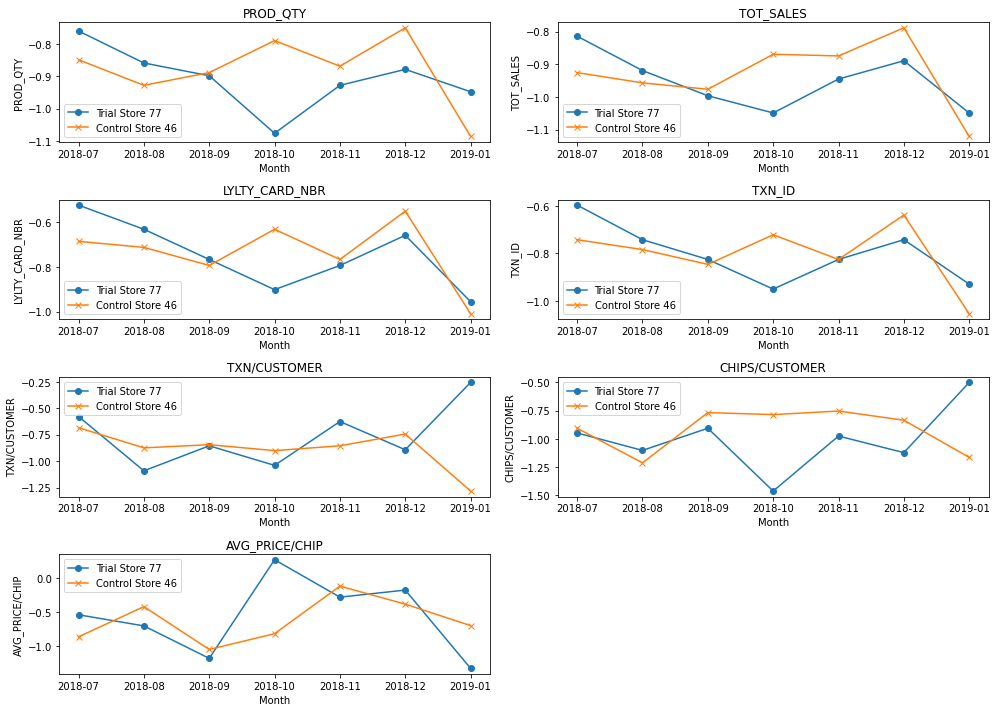

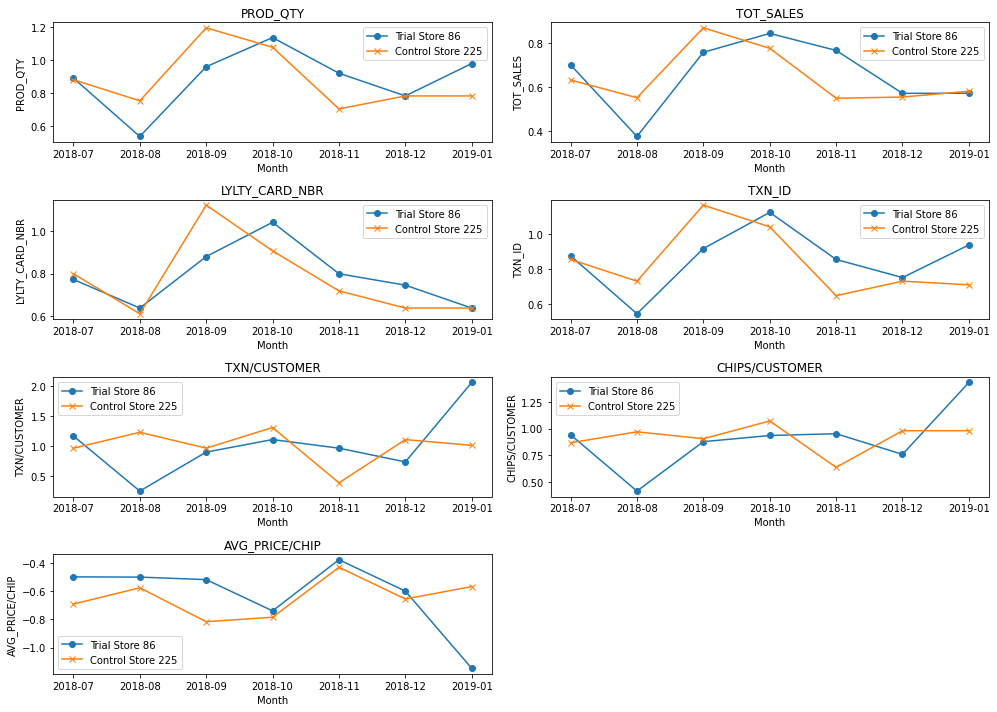

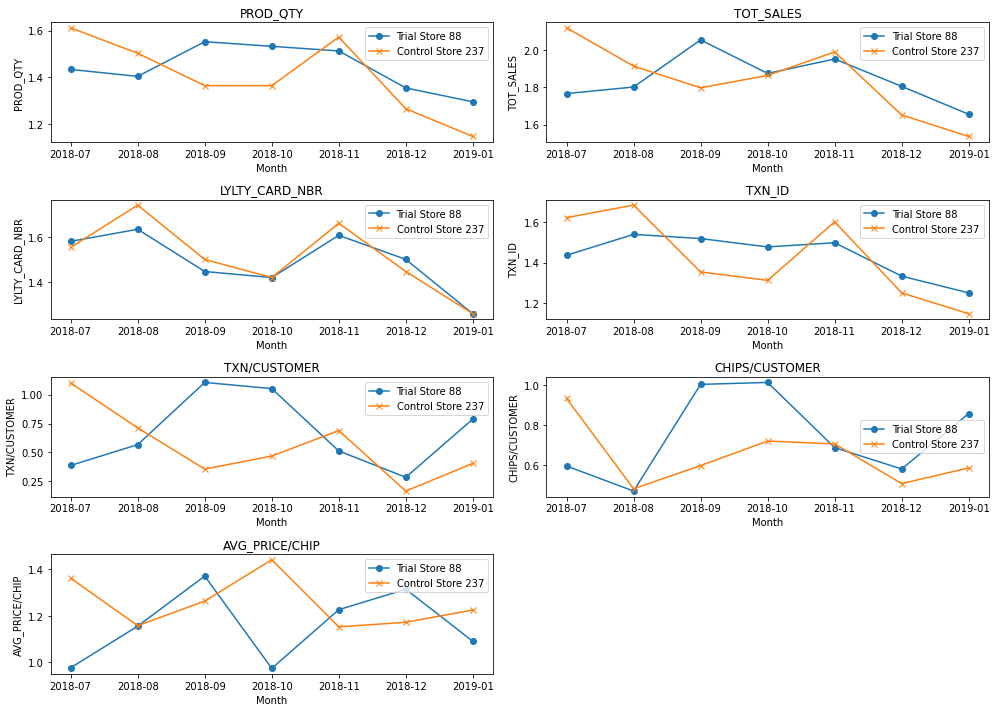

In [35]:
trial_control_pairs = [(77, 46), (86, 225), (88, 237)]
store_data = get_store_data([store for pair in trial_control_pairs for store in pair])

# Plot the metrics over time for each trial store and its corresponding control store
def plot_metrics(trial_store, control_store):
    trial_data = store_data[store_data['STORE_NBR'] == trial_store].sort_values('DATE')
    control_data = store_data[store_data['STORE_NBR'] == control_store].sort_values('DATE')
    
    metrics = ['PROD_QTY', 'TOT_SALES', 'LYLTY_CARD_NBR', 'TXN_ID', 'TXN/CUSTOMER', 'CHIPS/CUSTOMER', 'AVG_PRICE/CHIP']
    months = trial_data['DATE'].unique()
    
    plt.figure(figsize=(14, 10))
    for i, metric in enumerate(metrics, 1):
        plt.subplot(4, 2, i)
        plt.plot(months, trial_data[metric], label=f'Trial Store {trial_store}', marker='o')
        plt.plot(months, control_data[metric], label=f'Control Store {control_store}', marker='x')
        plt.title(metric)
        plt.xlabel('Month')
        plt.ylabel(metric)
        plt.legend()
        
    plt.tight_layout()
    plt.show()

# Plot for each trial-control pair
for trial_store, control_store in trial_control_pairs:
    plot_metrics(trial_store, control_store)


We can see from the charts above, they have very close metrics, not a perfect match, but very close

# Analysis of the trial store compared with the Control store

In a similar fashion, we would seperate the data into the trial and observation period(Feb 2019 - Apr 2019). We would then summarise the data to show the stores and their respective transaction history per month

In [36]:
post_trial = df[(df['DATE'] >= '2019-02') & (df['DATE']<='2019-04')] 

In [37]:
post_trial_monthly = post_trial.pivot_table(index=['STORE_NBR','DATE'], values = ['TOT_SALES','PROD_QTY'], 
                                        aggfunc = np.sum).reset_index()
post_trial_monthly

,STORE_NBR,DATE,PROD_QTY,TOT_SALES
0,1,2019-02,65,225.4
1,1,2019-03,58,192.9
2,1,2019-04,57,192.9
3,2,2019-02,37,139.4
4,2,2019-03,51,192.1
...,...,...,...,...
789,271,2019-03,202,735.8
790,271,2019-04,218,774.6
791,272,2019-02,91,395.5
792,272,2019-03,101,442.3


In [38]:
post_trial_monthly_customers = post_trial.groupby(['STORE_NBR','DATE'])['LYLTY_CARD_NBR'].nunique().reset_index()

In [39]:
post_trial_monthly_transactions = post_trial.groupby(['STORE_NBR','DATE'])['TXN_ID'].nunique().reset_index()

In [40]:
monthly_post_trial1 = pd.merge(post_trial_monthly,post_trial_monthly_customers , on = ['STORE_NBR','DATE'], how = 'outer')

In [41]:
monthly_post_trial = pd.merge(monthly_post_trial1, post_trial_monthly_transactions, on= ['STORE_NBR','DATE'], how = 'outer')

In [42]:
monthly_post_trial['TXN/CUSTOMER'] = monthly_post_trial['TXN_ID']/monthly_post_trial['LYLTY_CARD_NBR']
monthly_post_trial['CHIPS/CUSTOMER'] = monthly_post_trial['PROD_QTY']/monthly_post_trial['LYLTY_CARD_NBR']
monthly_post_trial['AVG_PRICE/CHIP'] = monthly_post_trial['TOT_SALES']/monthly_post_trial['PROD_QTY']

In [43]:
monthly_post_trial

,STORE_NBR,DATE,PROD_QTY,TOT_SALES,LYLTY_CARD_NBR,TXN_ID,TXN/CUSTOMER,CHIPS/CUSTOMER,AVG_PRICE/CHIP
0,1,2019-02,65,225.4,52,55,1.057692,1.250000,3.467692
1,1,2019-03,58,192.9,45,49,1.088889,1.288889,3.325862
2,1,2019-04,57,192.9,42,43,1.023810,1.357143,3.384211
3,2,2019-02,37,139.4,29,32,1.103448,1.275862,3.767568
4,2,2019-03,51,192.1,43,46,1.069767,1.186047,3.766667
...,...,...,...,...,...,...,...,...,...
789,271,2019-03,202,735.8,79,101,1.278481,2.556962,3.642574
790,271,2019-04,218,774.6,87,109,1.252874,2.505747,3.553211
791,272,2019-02,91,395.5,45,48,1.066667,2.022222,4.346154
792,272,2019-03,101,442.3,50,53,1.060000,2.020000,4.379208


Like we did to summarise the transaction of each store for the Pre trial period, we have done the same with the post trial

In [44]:
trial_post_data = monthly_post_trial[monthly_post_trial['STORE_NBR'].isin([77,86,88])]
control_post_data = monthly_post_trial[monthly_post_trial['STORE_NBR'].isin([46,225,237])]
#exracting the post trial data for the trial and control stores

In [45]:
trial_data = monthly_pretrial[monthly_pretrial['STORE_NBR'].isin([77,86,88])]
#extracting the pre trial data for the trial and control stores

In [46]:
control_data = monthly_pretrial[monthly_pretrial['STORE_NBR'].isin([46,225,237])]

In [47]:
trial_post_data['Period'] = 'Post-Trial'
control_post_data['Period'] = 'Post-Trial'
trial_data['Period'] = 'Pre-Trial'
control_data['Period'] = 'Pre-Trial'

C:\Users\EBUKAO~1\AppData\Local\Temp/ipykernel_18256/2235948998.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trial_post_data['Period'] = 'Post-Trial'
C:\Users\EBUKAO~1\AppData\Local\Temp/ipykernel_18256/2235948998.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_post_data['Period'] = 'Post-Trial'
C:\Users\EBUKAO~1\AppData\Local\Temp/ipykernel_18256/2235948998.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [50]:
trial_combined_data = pd.concat([trial_data,trial_post_data])

In [51]:
control_combined_data = pd.concat([control_data, control_post_data])

# Analysis

#### The next series of codes are alot and here is what i'm trying to do. I have the transaction data of the trial and control store before and after the trial. I am going to write a function to calculate the metrics i'll be using to compare the two store, I will plot the metrics to visualize the how it performs over time, I will calculate the percentage change in the pre and post trial values, i will calculate a pearson correlation to calculate how similar the end result is. The point of all this is to plot charts that would compare the values of the metrics of the trial and control store before and after the trial

In [52]:
store_pairs = [(77,46), (86,225), (88,237)]

In [53]:
#Function to calculate metrics
def calculate_metrics(data):
    metrics = data.groupby('Period').agg({
        'PROD_QTY': 'mean', 
        'TOT_SALES': 'mean', 
        'LYLTY_CARD_NBR': 'mean',
        'TXN_ID': 'mean', 
        'TXN/CUSTOMER': 'mean', 
        'CHIPS/CUSTOMER':'mean',
        'AVG_PRICE/CHIP':'mean'
    }).reset_index()
    return metrics

In [54]:
#function to plot metrics
def plot_metrics(trial_metrics, control_metrics, metric_name, trial_store, control_store):
    plt.figure(figsize=(10,6))
    plt.plot(trial_metrics['Period'], trial_metrics[metric_name], label = f'Trial Store {trial_store}', marker = 'o')
    plt.plot(control_metrics['Period'], control_metrics[metric_name], label=f'Control Store {control_store}', marker = 'o')
    plt.title(f'Comparison of {metric_name} for Trial Store {trial_store} and Control Store {control_store}')
    plt.xlabel('Period')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.show()

In [55]:
#Function to calculate percentage change
def calculate_percentage_change(data, metric):
    pre_trial_value = data.loc[data['Period'] == 'Pre-Trial', metric].values[0]
    post_trial_value = data.loc[data['Period'] == 'Post-Trial', metric].values[0]
    return ((post_trial_value - pre_trial_value) / pre_trial_value) * 100

In [56]:
from scipy.stats import pearsonr

In [57]:
#function to calculate Pearson correlation
def calculate_pearson_correlation(trial_data, control_data, metric):
    trial_values = trial_data[metric].values
    control_values = control_data[metric].values
    return pearsonr(trial_values,control_values)[0]

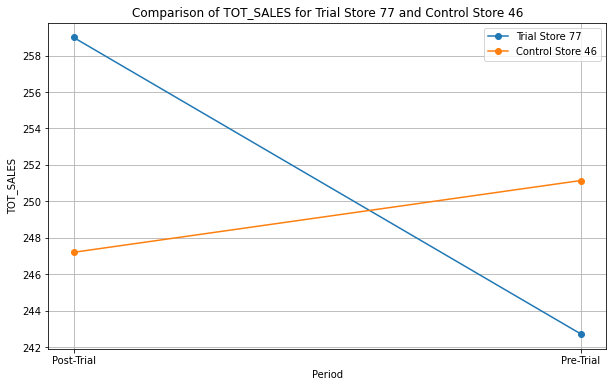

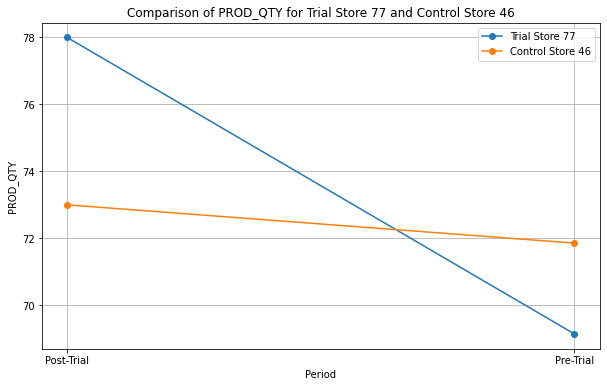

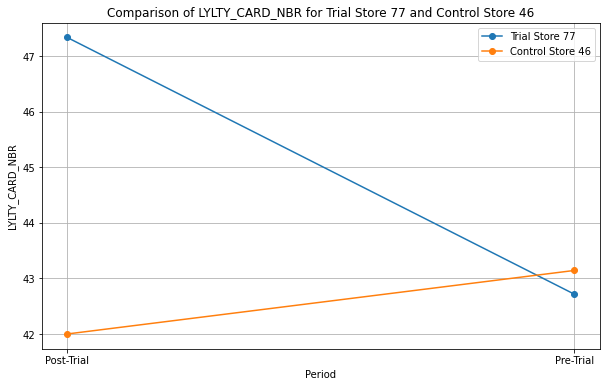

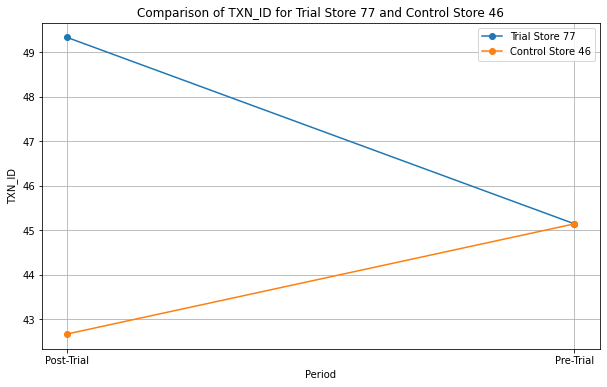

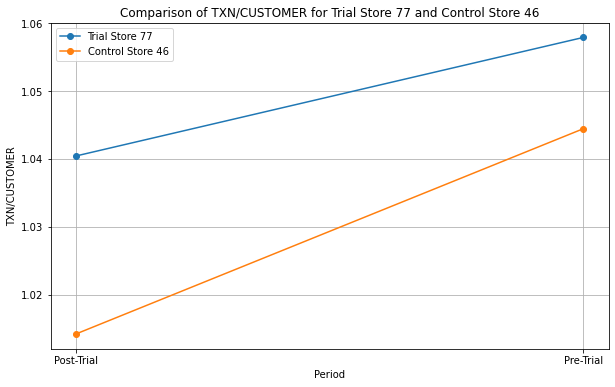

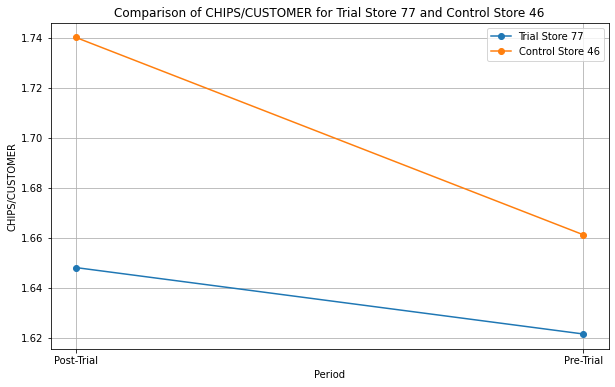

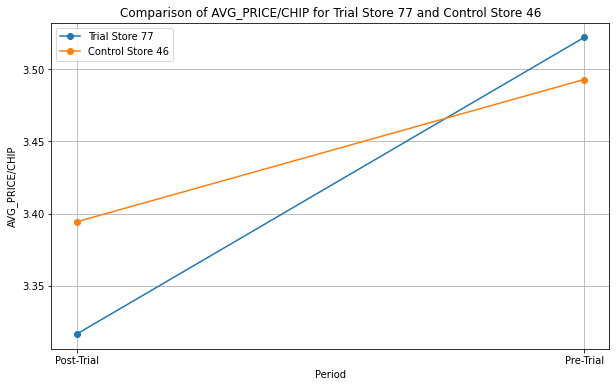

Percentage Changes for Trial Store 77 and Control Store 46
                Trial Store 77  Control Store 46
TOT_SALES             6.709829         -1.569966
PROD_QTY             12.809917          1.590457
LYLTY_CARD_NBR       10.813824         -2.649007
TXN_ID                9.282700         -5.485232
TXN/CUSTOMER         -1.651658         -2.896745
CHIPS/CUSTOMER        1.638210          4.750577
AVG_PRICE/CHIP       -5.828607         -2.819412


Pearson Correlation for Trial Store 77 and Control Store 46
                Pearson Correlation
TOT_SALES                  0.454297
PROD_QTY                   0.020603
LYLTY_CARD_NBR             0.405574
TXN_ID                     0.276538
TXN/CUSTOMER              -0.226775
CHIPS/CUSTOMER            -0.323740
AVG_PRICE/CHIP             0.372488




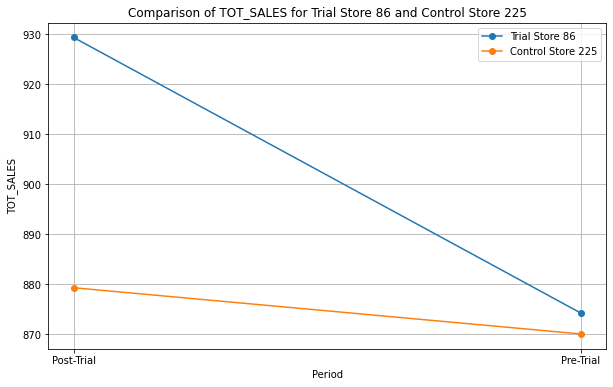

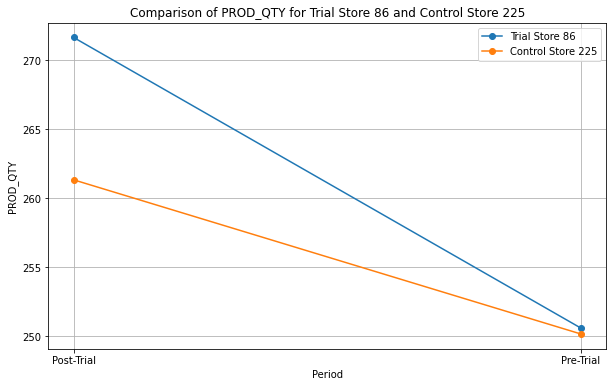

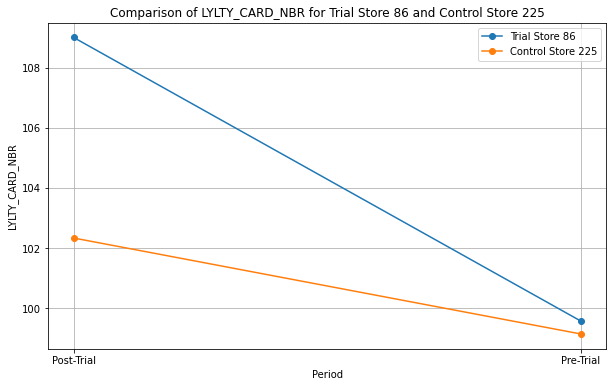

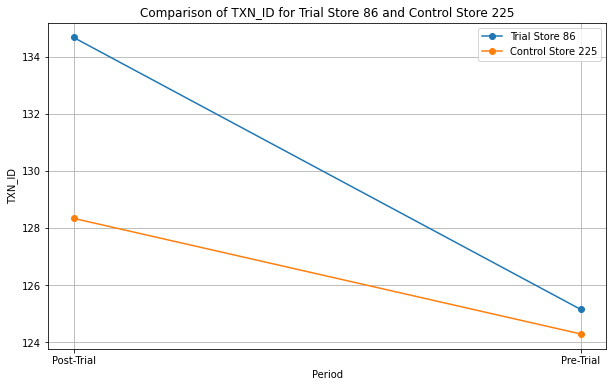

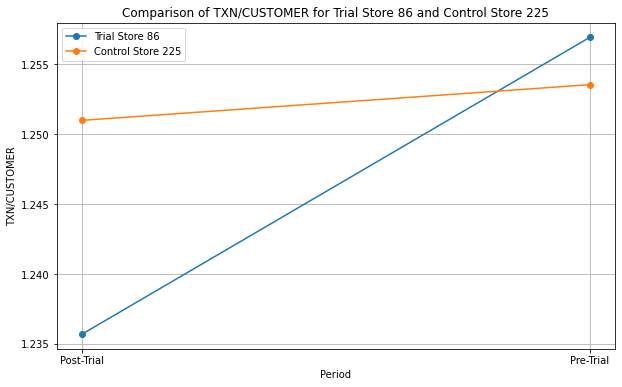

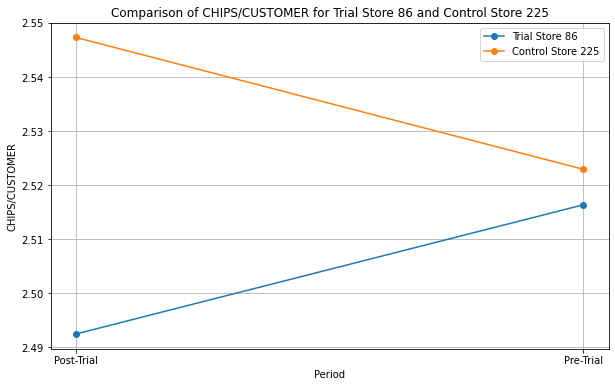

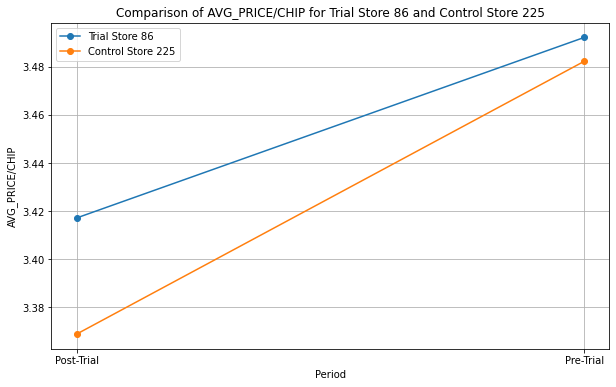

Percentage Changes for Trial Store 86 and Control Store 225
                Trial Store 86  Control Store 225
TOT_SALES             6.306527           1.062840
PROD_QTY              8.418852           4.473634
LYLTY_CARD_NBR        9.469154           3.218060
TXN_ID                7.610350           3.256705
TXN/CUSTOMER         -1.689123          -0.203539
CHIPS/CUSTOMER       -0.949374           0.966117
AVG_PRICE/CHIP       -2.145200          -3.250778


Pearson Correlation for Trial Store 86 and Control Store 225
                Pearson Correlation
TOT_SALES                 -0.052470
PROD_QTY                   0.123722
LYLTY_CARD_NBR             0.415089
TXN_ID                     0.066672
TXN/CUSTOMER              -0.204377
CHIPS/CUSTOMER            -0.170770
AVG_PRICE/CHIP            -0.047521




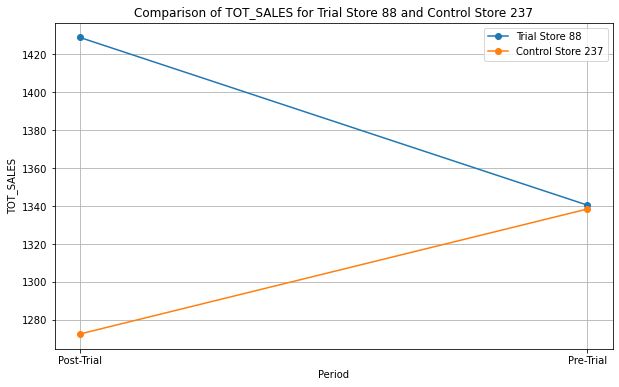

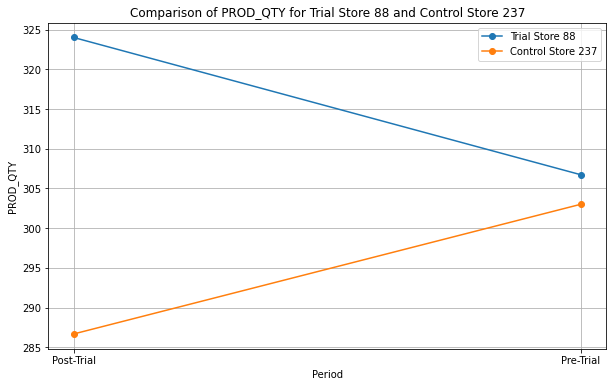

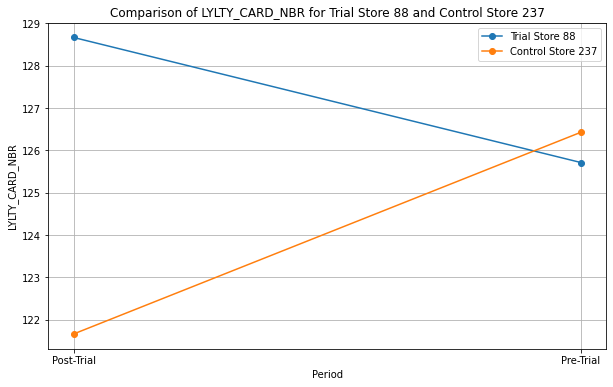

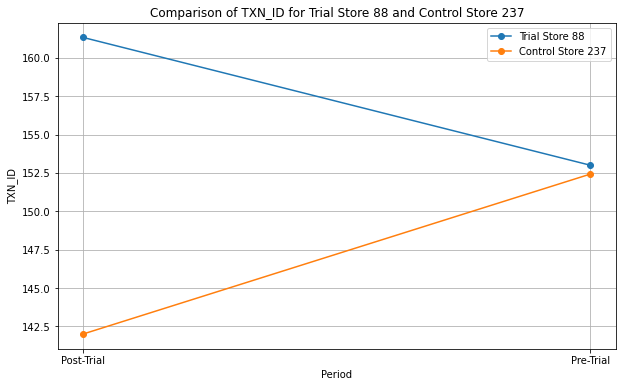

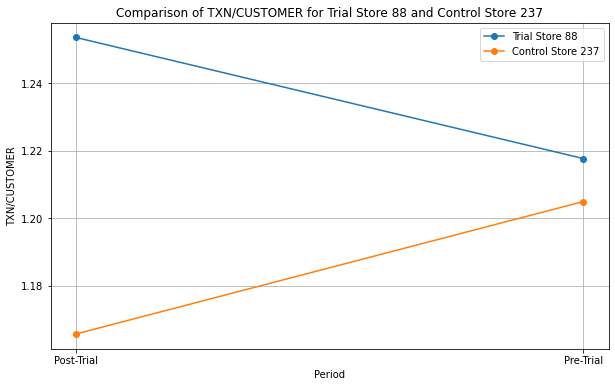

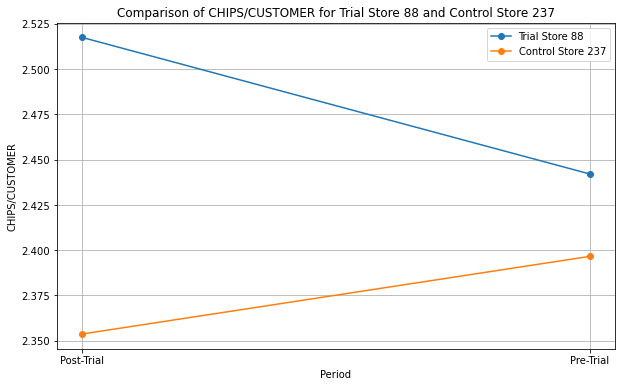

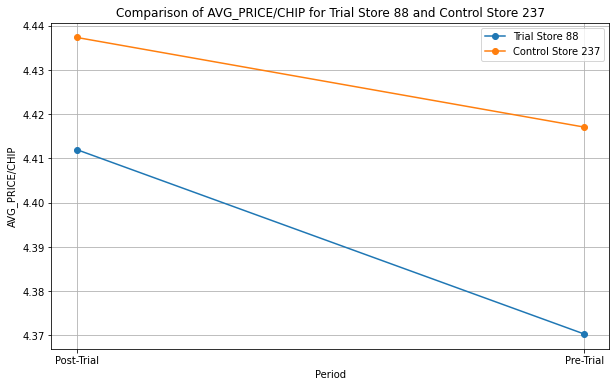

Percentage Changes for Trial Store 88 and Control Store 237
                Trial Store 88  Control Store 237
TOT_SALES             6.595905          -4.923329
PROD_QTY              5.635771          -5.390539
LYLTY_CARD_NBR        2.348485          -3.766478
TXN_ID                5.446623          -6.841612
TXN/CUSTOMER          2.946167          -3.256517
CHIPS/CUSTOMER        3.085511          -1.787276
AVG_PRICE/CHIP        0.953176           0.458490


Pearson Correlation for Trial Store 88 and Control Store 237
                Pearson Correlation
TOT_SALES                 -0.315527
PROD_QTY                  -0.305424
LYLTY_CARD_NBR             0.415012
TXN_ID                    -0.204416
TXN/CUSTOMER              -0.512482
CHIPS/CUSTOMER            -0.124306
AVG_PRICE/CHIP            -0.390735




In [58]:
#Calculate and plot metrics for each store pair
for trial_store,control_store in store_pairs:
    trial_store_data = trial_combined_data[trial_combined_data['STORE_NBR'] == trial_store]
    control_store_data = control_combined_data[control_combined_data['STORE_NBR'] == control_store]
    
    trial_metrics = calculate_metrics(trial_store_data)
    control_metrics = calculate_metrics(control_store_data)
    
    metrics_to_plot = ['TOT_SALES', 'PROD_QTY', 'LYLTY_CARD_NBR', 'TXN_ID', 'TXN/CUSTOMER', 'CHIPS/CUSTOMER', 'AVG_PRICE/CHIP']
    
    for metric in metrics_to_plot:
        plot_metrics(trial_metrics, control_metrics, metric, trial_store, control_store)
        
    #Calculate percentage change and Pearson correlation for trial and control stores
    percentage_changes = {}
    correlations = {}
    for metric in metrics_to_plot:
        trial_change = calculate_percentage_change(trial_metrics, metric)
        control_change = calculate_percentage_change(control_metrics, metric)
        correlation = calculate_pearson_correlation(trial_store_data, control_store_data, metric)
        percentage_changes[metric] = {f'Trial Store {trial_store}':trial_change,
                                      f'Control Store {control_store}':control_change}
        correlations[metric] = correlation
        
    #Display percentage changes and pearson correlations
    percentage_changes_df = pd.DataFrame(percentage_changes).transpose()
    correlations_df = pd.DataFrame(correlations, index = ['Pearson Correlation']).transpose()
    
    print(f'Percentage Changes for Trial Store {trial_store} and Control Store {control_store}')
    print(percentage_changes_df)
    print('\n')
    print(f'Pearson Correlation for Trial Store {trial_store} and Control Store {control_store}')
    print(correlations_df)
    print('\n')

Now let us plot and visualize key metrices, comparing the trial and control stores percentage changes

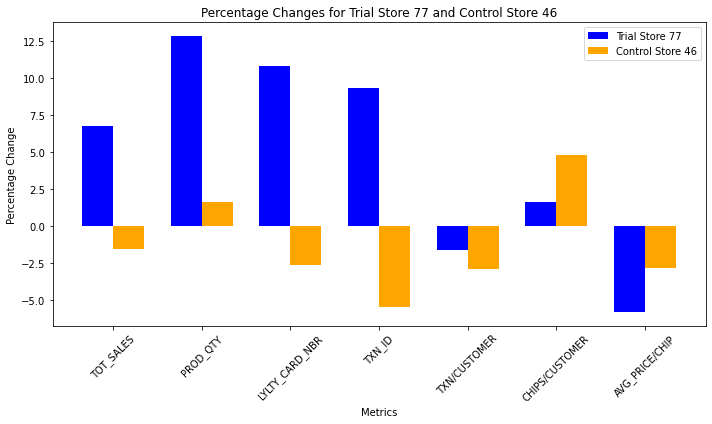

In [59]:
# Data to visualize
metrics = ['TOT_SALES', 'PROD_QTY', 'LYLTY_CARD_NBR', 'TXN_ID', 'TXN/CUSTOMER', 'CHIPS/CUSTOMER', 'AVG_PRICE/CHIP']
trial_store_77 = [6.709829, 12.809917, 10.813824, 9.282700, -1.651658, 1.638210, -5.828607]
control_store_46 = [-1.569966, 1.590457, -2.649007, -5.485232, -2.896745, 4.750577, -2.819412]

# Create a bar chart
bar_width = 0.35
index = np.arange(len(metrics))

plt.figure(figsize=(10, 6))

# Bars for trial store
bars1 = plt.bar(index, trial_store_77, bar_width, label='Trial Store 77', color='blue')

# Bars for control store
bars2 = plt.bar(index + bar_width, control_store_46, bar_width, label='Control Store 46', color='orange')

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Percentage Change')
plt.title('Percentage Changes for Trial Store 77 and Control Store 46')
plt.xticks(index + bar_width / 2, metrics, rotation=45)
plt.legend()

# Display the chart
plt.tight_layout()
plt.show()

TRIAL STORE  77 vs. CONTROL STORE 46

Trial Store 77 shows positive percentage changes in most metrics, including TOT_SALES, PROD_QTY, LYLTY_CARD_NBR, and TXN_ID. This suggests an overall improvement in performance during the experimental period.

Control Store 46, on the other hand, shows negative percentage changes in most of these same metrics, indicating a decline in performance.

The divergence between the trial store's positive changes and the control store's negative or neutral changes suggests that the experiment had a positive impact on the performance of Trial Store 77.

We can see a big increase in the total sales and this can be attributed to increased number of products being bought,increased customers, but however, there is a little decline in the number of transactions per customer. It should also be noted that mostly the less expensive chips was being bought here.

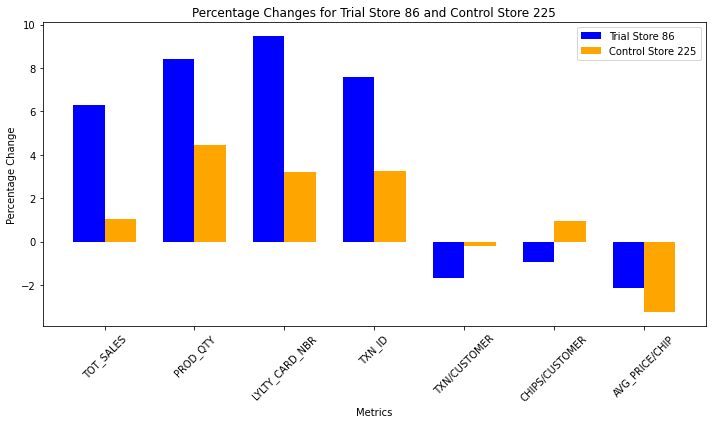

In [62]:
# Data to visualize
metrics = ['TOT_SALES', 'PROD_QTY', 'LYLTY_CARD_NBR', 'TXN_ID', 'TXN/CUSTOMER', 'CHIPS/CUSTOMER', 'AVG_PRICE/CHIP']
trial_store_86 = [6.306527, 8.418852, 9.469154, 7.610350, -1.689123, -0.949374, -2.145200]
control_store_225 = [1.062840, 4.473634, 3.218060, 3.256705, -0.203539, 0.966117, -3.250778]
# Create a bar chart
bar_width = 0.35
index = np.arange(len(metrics))
plt.figure(figsize=(10, 6))
# Bars for trial store
bars1 = plt.bar(index, trial_store_86, bar_width, label='Trial Store 86', color='blue')
# Bars for control store
bars2 = plt.bar(index + bar_width, control_store_225, bar_width, label='Control Store 225', color='orange')
# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Percentage Change')
plt.title('Percentage Changes for Trial Store 86 and Control Store 225')
plt.xticks(index + bar_width / 2, metrics, rotation=45)
plt.legend()
# Display the chart
plt.tight_layout()
plt.show()

TRIAL STORE 86 vs. CONTROL STORE 225

Both Trial Store 86 and Control Store 225 show positive percentage changes in most metrics. However, the magnitude of the increase is generally higher for Trial Store 86.

The differences between the trial and control stores are less pronounced than in the first comparison. Metrics like TXN/CUSTOMER and CHIPS/CUSTOMER show minimal changes for both stores.

Over here we can see also a significant positive change in the total sales, which can be attributed to the increased number of customers which in turn increases the number of products being bought. Again there is a small decline in the quantity of chips bought per customer

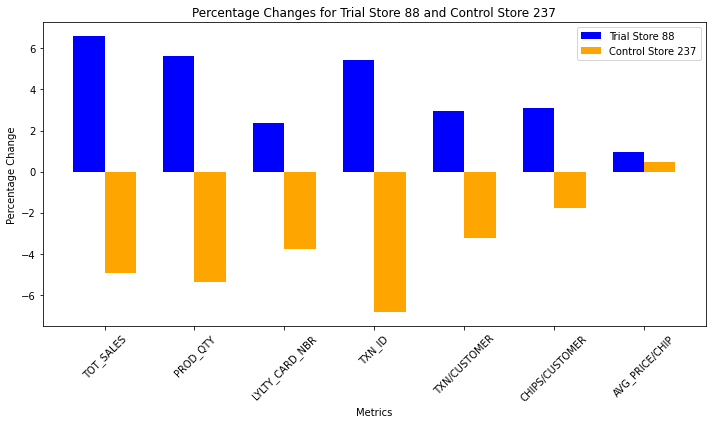

In [61]:
# Data to visualize
metrics = ['TOT_SALES', 'PROD_QTY', 'LYLTY_CARD_NBR', 'TXN_ID', 'TXN/CUSTOMER', 'CHIPS/CUSTOMER', 'AVG_PRICE/CHIP']
trial_store_88 = [6.595905, 5.635771, 2.348485, 5.446623, 2.946167, 3.085511, 0.953176]
control_store_237 = [-4.923329, -5.390539, -3.766478, -6.841612, -3.256517, -1.787276, 0.458490]
# Create a bar chart
bar_width = 0.35
index = np.arange(len(metrics))
plt.figure(figsize=(10, 6))
# Bars for trial store
bars1 = plt.bar(index, trial_store_88, bar_width, label='Trial Store 88', color='blue')
# Bars for control store
bars2 = plt.bar(index + bar_width, control_store_237, bar_width, label='Control Store 237', color='orange')
# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Percentage Change')
plt.title('Percentage Changes for Trial Store 88 and Control Store 237')
plt.xticks(index + bar_width / 2, metrics, rotation=45)
plt.legend()
# Display the chart
plt.tight_layout()
plt.show()

TRIAL STORE 88 vs. CONTROL STORE 237

Trial Store 88 shows positive percentage changes across all metrics, while Control Store 237 shows negative percentage changes in most metrics except for AVG_PRICE/CHIP.

The big contrast between the trial store's positive performance and the control store's negative performance suggests that the experiment had a notably positive impact on Trial Store 88 and was highly effective in improving performance.

We can see an increased Total sales and it can be attributed to an increased purchase per customer. Unlike trial store 77 and 86, the increase in number of customers is considerably less here.  



# Overall Deduction

The experiment seems to have had a positive impact on all three trial stores, as evidenced by the overall positive percentage changes in key metrics like TOT_SALES, PROD_QTY, and TXN_ID. This is especially apparent when compared to the control stores, which either showed negative changes or less pronounced positive changes.

The extent of the impact varies across the three trial stores. Trial Store 88, in particular, shows the most significant positive divergence from its control store, suggesting a very strong effect of the experiment.

The control stores generally show either neutral or negative changes, indicating that the trial stores' improvements are likely due to the experimental intervention rather than external factors affecting all stores equally.

With all the analysis done, it is safe to say the experiment is a success and it can be crried out on all other stores to boost their sales. 

Thankyou.